# Battery_SoC_LSTM_with"Time"

In [41]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

## Load and clean the datasets

In [152]:
data_file = "./TripB14.csv"

In [153]:
data = pd.read_csv(data_file, encoding="ISO-8859-1", sep=";")

In [154]:
def get_soc_using_coulomb_counting_method(df, battery_voltage, battery_usable_capacity_kWh):
    
    estimated_soc = []
    
    SOC_0 = df["SoC [%]"][0]  # Initial State of Charge in %
    
    # Convert capacity to Ampere-seconds (As) using battery voltage
    Q_rated = (battery_usable_capacity_kWh * 1000) / battery_voltage * 3600   # Convert kWh to As
    
    # Time difference between samples
    time_difference = df['Time [s]'].diff().fillna(0)  # First diff is NaN, set to 0
    
    # Coulomb Counting Method to estimate SOC
    estimated_soc = SOC_0 + (df['Battery Current [A]'] * time_difference).cumsum() / Q_rated * 100
    
    return estimated_soc

In [155]:
# Estimate SoC using Coulomb counting method on all dataframes

data["Estimated SoC (Coulomb counting method)"] = get_soc_using_coulomb_counting_method(df=data, battery_voltage=360, battery_usable_capacity_kWh=18.8)

In [156]:
# Difference between SoC and Estimated SoC

data["Delta"] = data["SoC [%]"] - data["Estimated SoC (Coulomb counting method)"]

In [157]:
key_features = ["Time [s]", "Velocity [km/h]", "Battery Voltage [V]", "Battery Current [A]", "Battery Temperature [°C]"]

In [158]:
# Extract features and target variable
X = data[key_features]  # Features 
y = data["Delta"]   # Target (Difference between SoC and Estimated SoC)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.33, shuffle=False)

## Convert Data to PyTorch form

In [159]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)


In [160]:
# Convert data into sliding windows

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_length=10):
  
        self.seq_length = seq_length
        self.features = X    # shape: (num_samples, 5)
        self.targets = y.values       # shape: (num_samples,)
        
    def __len__(self):
        
        return len(self.features) - self.seq_length
    
    def __getitem__(self, idx):
        
        x_seq = self.features[idx: idx + self.seq_length]  
        y_seq = self.targets[idx + self.seq_length - 1]     
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).unsqueeze(0)


        

In [161]:
seq_length = 10   # Sliding window length

# Create the Data loader
train_dataset = TimeSeriesDataset(X_train_scaled, y_train, seq_length)
validation_dataset = TimeSeriesDataset(X_validation_scaled, y_validation, seq_length)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test, seq_length)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Define the LSTM model

In [162]:
class LSTMRegressor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout  
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout_fc = nn.Dropout(p=dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout_fc(out)
        out = self.fc(out)
        return out

In [163]:
# Initialize model
input_dim = len(key_features)  # Number of features
hidden_dim = 32  # Hidden state size
output_dim = 1  # Single output (Delta)
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.2

model = LSTMRegressor(input_dim, hidden_dim, num_layers, output_dim)

## Loss Function

In [164]:
def rmse_loss(y_true, y_pred):
    
    mse_loss = nn.functional.mse_loss(y_pred, y_true) 
    
    return torch.sqrt(mse_loss + 1e-8)  

In [165]:
def mae_loss(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


## Model Training

In [166]:
# Move the Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMRegressor(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (dropout_fc): Dropout(p=0.2, inplace=False)
)

In [167]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5) 
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # epoch % 10 == 0, lr * 0.1

In [168]:
# Training loop
num_epochs = 100
best_val_loss = 1000
early_stop_counter = 0  
patience = 30

train_rmse_losses = []
train_mae_losses = []
val_rmse_losses = []
val_mae_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_rmse = 0.0
    train_mae = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = rmse_loss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_rmse += loss.item() * batch_x.size(0)
        train_mae += mae_loss(outputs, batch_y).item() * batch_x.size(0)
    
    train_rmse /= len(train_dataset)
    train_mae /= len(train_dataset)
    train_rmse_losses.append(train_rmse)
    train_mae_losses.append(train_mae)
    
    # Validation
    model.eval()
    val_rmse = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for batch_x, batch_y in validation_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            loss = rmse_loss(outputs, batch_y)
            val_rmse += loss.item() * batch_x.size(0)
            val_mae += mae_loss(outputs, batch_y).item() * batch_x.size(0)
            
    val_rmse /= len(validation_dataset)
    val_mae /= len(validation_dataset)
    val_rmse_losses.append(val_rmse)
    val_mae_losses.append(val_mae)

    scheduler.step()  
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train RMSE: {train_rmse:.4f}| Train MAE: {train_mae:.4f}| "
          f"Val RMSE: {val_rmse:.4f}| Val MAE: {val_mae:.4f}| Current Learning Rate: {current_lr:.8f}")


    # Early stopping
    if val_rmse < best_val_loss:
        best_val_loss = val_rmse
        best_val_mae = val_mae
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break


Epoch [1/100], Train RMSE: 0.5141| Train MAE: 0.3931| Val RMSE: 1.5732| Val MAE: 1.5726| Current Learning Rate: 0.10000000
Epoch [2/100], Train RMSE: 0.3783| Train MAE: 0.2867| Val RMSE: 1.5525| Val MAE: 1.5522| Current Learning Rate: 0.10000000
Epoch [3/100], Train RMSE: 0.3544| Train MAE: 0.2689| Val RMSE: 1.3476| Val MAE: 1.3465| Current Learning Rate: 0.10000000
Epoch [4/100], Train RMSE: 0.3347| Train MAE: 0.2508| Val RMSE: 1.4313| Val MAE: 1.4306| Current Learning Rate: 0.10000000
Epoch [5/100], Train RMSE: 0.3282| Train MAE: 0.2472| Val RMSE: 1.1337| Val MAE: 1.1331| Current Learning Rate: 0.10000000
Epoch [6/100], Train RMSE: 0.3155| Train MAE: 0.2372| Val RMSE: 1.3585| Val MAE: 1.3575| Current Learning Rate: 0.10000000
Epoch [7/100], Train RMSE: 0.3251| Train MAE: 0.2442| Val RMSE: 1.5102| Val MAE: 1.5094| Current Learning Rate: 0.10000000
Epoch [8/100], Train RMSE: 0.3379| Train MAE: 0.2526| Val RMSE: 0.9439| Val MAE: 0.9427| Current Learning Rate: 0.10000000
Epoch [9/100], T

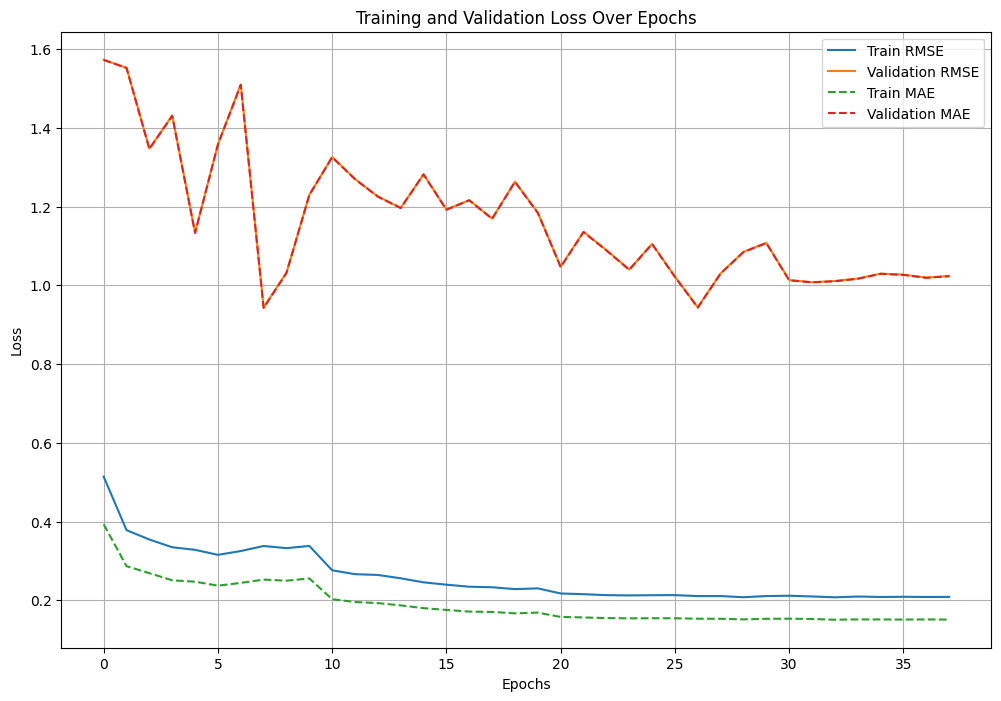

In [169]:
plt.figure(figsize=(12, 8))
plt.plot(train_rmse_losses, label="Train RMSE")
plt.plot(val_rmse_losses, label="Validation RMSE")
plt.plot(train_mae_losses, label="Train MAE", linestyle="--")
plt.plot(val_mae_losses, label="Validation MAE", linestyle="--")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [170]:
model.load_state_dict(best_model_state)  
model.eval()

with torch.no_grad():
    test_rmse = 0.0
    test_mae = 0.0  
    
    for batch_X, batch_y in test_loader:
        test_predictions = model(batch_X)
        test_rmse += rmse_loss(test_predictions, batch_y.view(-1, 1)).item()
        test_mae += mae_loss(test_predictions, batch_y.view(-1, 1)).item()  

    test_rmse /= len(test_loader)
    test_mae /= len(test_loader)

    print(f"Test Loss (RMSE): {test_rmse:.4f}")
    print(f"Test Loss (MAE): {test_mae:.4f}")


Test Loss (RMSE): 1.6508
Test Loss (MAE): 1.6506
